In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

#jax.config.update("jax_enable_x64", True)
print(jax.devices())

sys.path.append('../../')

from cofilin.forward_model.config import Constants, FMConfig
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.fourier import my_ifft, my_fft
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec
from cofilin.forward_model.utils import apply_wiener_filter 

[CudaDevice(id=0)]


/home/pere/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N, Z_I, Z_F = 64, 99, 0
R = 3.4*4
L = R*N

cte = Constants(N, L, Z_I, Z_F)

lpt_method = "2LPT"
MND = 1e-2
N_TR = L**3 * MND

det_bias_model = "PowerLaw"
stoch_bias_model = "Poisson"

cweb = None
soft_cweb = True
cweb_sharpness = 10

fm_cfg = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    det_bias_model=det_bias_model,
    stoch_bias_model=stoch_bias_model,
    cweb=cweb,
    soft_cweb=soft_cweb,
    cweb_sharpness=cweb_sharpness
)
fmodel = FModel(fm_cfg)

In [3]:
q_data = fmodel.input_arr(jax.random.PRNGKey(1))
delta_in_hat = fmodel.delta_in(q_data)
delta_in = my_ifft(delta_in_hat, cte.INV_L3)
delta_lpt = fmodel.delta_lpt(q_data)
get_n_tr_mean = fmodel.n_tr_mean()

key_params = jax.random.PRNGKey(0)
sks = jax.random.split(key_params, 3)
alpha = jax.random.normal(sks[0], (fm_cfg.n_regions,))*0.2 + 1
params = {"alpha": alpha}

params = manage_params(params)
n_tr_mean = get_n_tr_mean(delta_lpt, params)

key_sample = jax.random.PRNGKey(1)
n_tr_data = fmodel.sample_n_tr(n_tr_mean, key_sample, params=params)

In [20]:
delta_wf, q_wf = apply_wiener_filter(n_tr_data, cte)
delta_wf_2 = my_ifft(fmodel.delta_in(q_wf), cte.INV_L3)

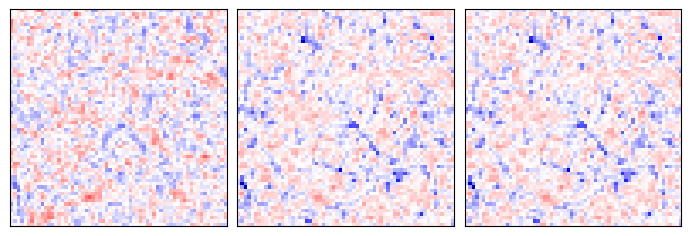

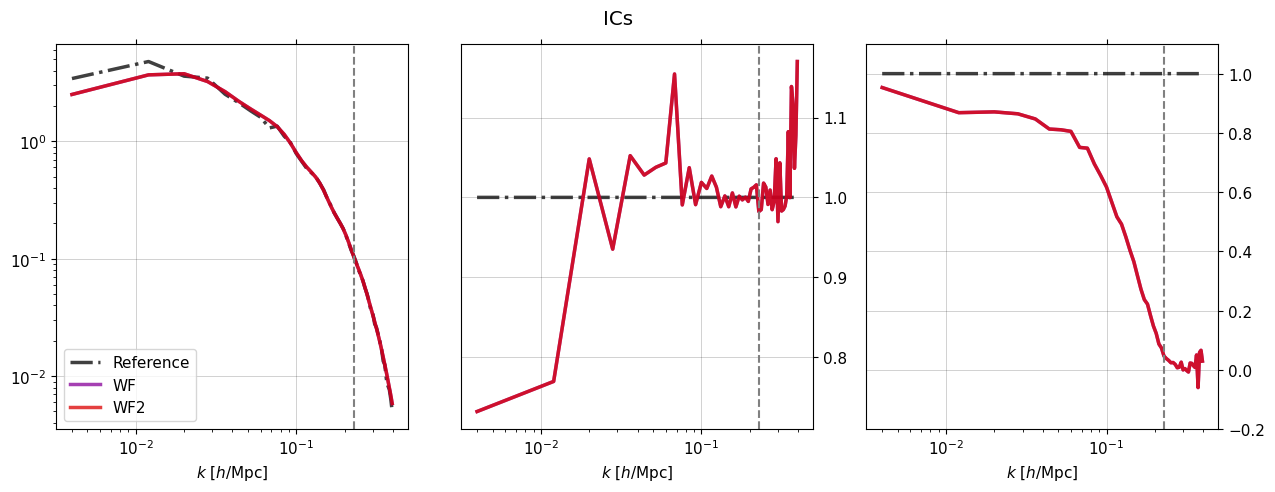

In [21]:
fig, ax = plot_cubes([delta_in, delta_wf, delta_wf_2], cmap='seismic_r', vlim=1e-1)

fig, ax = compare_pow_spec(
    [delta_in, delta_wf, delta_wf_2],
    L=L,
    xlog=True,
    labels=["Reference", "WF", "WF2"],
    title="ICs",
)

# ax[0].axhline(pk_noise)

In [ ]:
D1 = fmodel.cte.D1

pk_lm = fmodel.fm_cfg.pow_spec * D1**2
pk_noise = 1 / (n_tr_data.sum()/L**3)

delta_n_tr_data = (N**3 / n_tr_data.sum()) * n_tr_data - 1
delta_hat_n_tr_data = my_fft(delta_n_tr_data, cte.L3)
window = pk_lm / (pk_lm + pk_noise) 

delta_hat_wf = delta_hat_n_tr_data * window
delta_wf = my_ifft(delta_hat_wf, cte.INV_L3) / D1

pk_wf = (jnp.abs(delta_hat_wf)**2  * cte.INV_L3)

pk_wf = jnp.where(pk_wf!=0, pk_wf, 1.)

delta_hat_wf_2 = delta_hat_wf * jnp.sqrt(pk_lm) / jnp.sqrt(pk_wf) 

delta_wf_2 = my_ifft(delta_hat_wf_2, cte.INV_L3) / D1

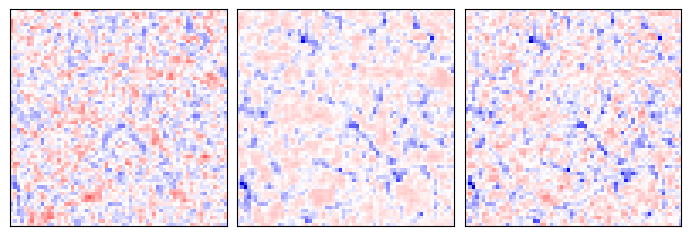

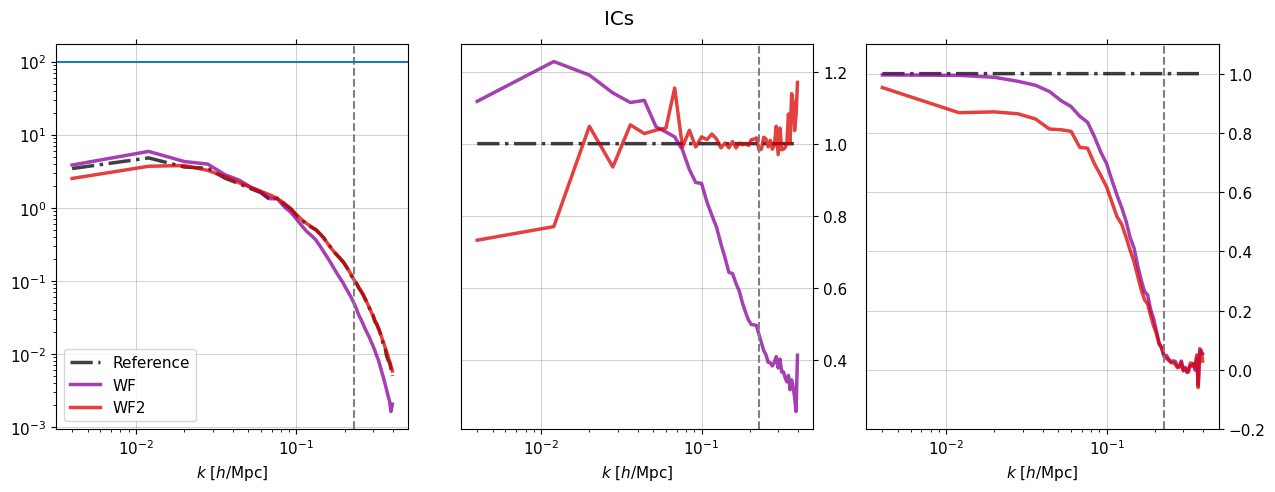

In [61]:
fig, ax = plot_cubes([delta_in, delta_wf, delta_wf_2], cmap='seismic_r', vlim=1e-1)

fig, ax = compare_pow_spec(
    [delta_in, delta_wf, delta_wf_2],
    L=L,
    xlog=True,
    labels=["Reference", "WF", "WF2"],
    title="ICs",
)

ax[0].axhline(pk_noise)

NameError: name 'pk_lm' is not defined